# ASTER Example
Adapted from the Ames Stereo Pipeline [documentation](https://stereopipeline.readthedocs.io/en/latest/examples.html?highlight=aster#aster-images)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import requests
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from distutils.spawn import find_executable
import dask
import zipfile
from pyproj import Proj, transform
import subprocess
from fetch_dem import opentopo_utils
import asp_binder_utils as asp_utils

In [3]:
print(dask.__version__)

2024.2.1


In [4]:
#dask.config.config

## Universal settings

In [5]:
verbose = False #  Will only print the bash commands and whether the process ran sucessfully or not
#verbose = True # will print all the logs printed by ASP
output_res = 30 # m resolution for output DEM
#tsrs = '+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs' # UTM projection of output DEM, orthoimages
tsrs = 'EPSG:32610' # projection of output DEM, orthoimages
map_res = 15 # m  resolution for orthorectified input stereo pair

## Preprocessing 0: Data Download

- ASTER L1A data can be ordered from NASA EarthDATA, from https://search.earthdata.nasa.gov/search
- Please select the GeoTiff dilevery before placing the order
- You will get an email when the order is ready, download the zip file.
- You can upload the dataset (zip_file) directly on the binder instance using the file viewer tab on your left
- For the purpose of this tutorial, we have downloaded and staged a sample dataset on zenodo, which can be accessed [here](https://zenodo.org/record/7972223#.ZG_qwdLMJhF)
- The dataset is a stereo pair over Mt. Rainier stratovolcano in Washington state

In [6]:
#ASTER Sample has been staged on Zenodo:
#https://zenodo.org/record/7972223/files/AST_L1A_00307312017190728_20200218153629_19952.zip?download=1
zenodo_url = 'https://zenodo.org/record/7972223/files/AST_L1A_00307312017190728_20200218153629_19952.zip?download=1'
fn = 'aster.zip'
if os.path.exists(fn):
    print(f"file {fn} already downloaded")
else:
    response = requests.get(zenodo_url)
    #Check for 200
    if response.ok:
        print ('OK!')
    else:
        print ('Query failed')
        sys.exit()
    #Write to disk
    open(fn, 'wb').write(response.content)
    print(f"file {fn} saved")

OK!
file aster.zip saved


In [7]:
aster_top_dir = 'aster_example'
with zipfile.ZipFile(fn, 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall(aster_top_dir)

## Preprocessing 1: Create left and right image and assosciated camera models (RPC and rigorous)

- `aster2asp` command takes in the unzipped ASTER image directory and produces 4 files
- Left and right image pairs (Band 3N and Band 3B)
- Two .xml files containing camera information for the left and right image
- The .xml files have both rigrous and RPC camera information

In [8]:
aster2asp = find_executable('aster2asp')
outfolder = 'aster_example_asp/out'
aster2asp_call = f'{aster2asp} {aster_top_dir} -o {outfolder}'

In [9]:
asp_utils.run_bash_command(aster2asp_call,verbose=verbose)

/srv/StereoPipeline/bin/aster2asp aster_example -o aster_example_asp/out


Child returned 0


## 3. Stereo Reconstruction and DEM Generation
- ASP can process an ASTER stereo pair using different modes, with customizable flags in each mode
- We give options for the 3 main modes, users can tweak the flags to see how it goes for them

### 3.1. Process with RPC camera
- First mode uses `RPC` camera for stereo triangulation and processing
- RPC is a set of polynomial function which is used to approximate actual camera sensor information
- This is the fastest mode to run, as the calculations required during stereo triangulation is minimal
- But as with any approximation, it is less accurate than the actual rigrous camera model

In [10]:
stereo = find_executable('stereo')
session = 'rpc'
stereo_algorithm = 'asp_bm'
spm = 1 
l_img = glob.glob(outfolder+'*3N.tif')[0]
r_img = glob.glob(outfolder+'*3B.tif')[0]
l_img_xml = glob.glob(outfolder+'*3N.xml')[0]
r_img_xml = glob.glob(outfolder+'*3B.xml')[0]
stereo_dir  = 'stereo_rpc/run'
stereo_call = f'{stereo} -t {session} --stereo-algorithm {stereo_algorithm}  --subpixel-mode {spm} {l_img} {r_img} {l_img_xml} {r_img_xml} {stereo_dir}'
asp_utils.run_bash_command(stereo_call,verbose=verbose)

/srv/StereoPipeline/bin/stereo -t rpc --stereo-algorithm asp_bm  --subpixel-mode 1 aster_example_asp/out-Band3N.tif aster_example_asp/out-Band3B.tif aster_example_asp/out-Band3N.xml aster_example_asp/out-Band3B.xml stereo_rpc/run


Child returned 0


In [12]:
point2dem = find_executable('point2dem')
tr = output_res
tsrs = tsrs
p2dem_args = '--errorimage'
pointcloud = glob.glob(stereo_dir+'*-PC.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call  = f"{point2dem} --tr {tr} --t_srs '{tsrs}' {p2dem_args} {pointcloud}"
asp_utils.run_bash_command(point2dem_call,verbose=verbose)
dem = glob.glob(stereo_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(dem))

Gridding pointcloud stereo_rpc/run-PC.tif at 30 m/px
/srv/StereoPipeline/bin/point2dem --tr 30 --t_srs 'EPSG:32610' --errorimage stereo_rpc/run-PC.tif
DEM saved at stereo_rpc/run-DEM.tif


Child returned 0


In [13]:
stereo_dir = 'stereo_rpc/run' 

Found files stereo_rpc/run-L.tif
 stereo_rpc/run-R.tif
 stereo_rpc/run-F.tif
 stereo_rpc/run-IntersectionErr.tif
 stereo_rpc/run-DEM.tif



/srv/conda/envs/notebook/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/srv/conda/envs/notebook/lib/python3.9/site-packages/matplotlib/image.py:513: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)


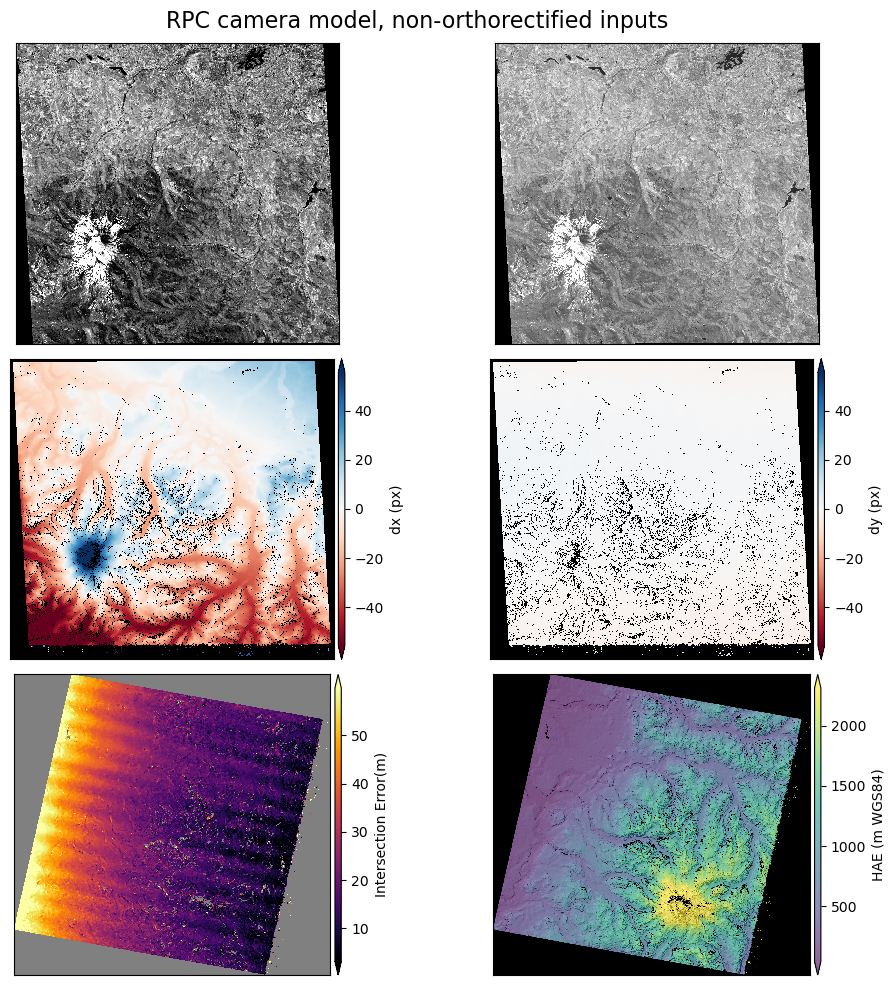

In [14]:
fig,ax = plt.subplots(3,2,figsize=(12,10))
asp_utils.plot_stereo_results(stereo_dir,ax)
fig.suptitle('RPC camera model, non-orthorectified inputs', fontsize=16)
plt.tight_layout()

- The first two images are the left and right stereo pairs
- Notice they might seem to be flipped ! This is because they are aligned along the affine epipolar line by `stereo_pprc`, so the ASP's matching algorithms search in the effective x direction only 
- The second row are the filtered sub-pixel disparity maps (pixel offsets in the right image corresponding to left image, you can see that most of the disparity is in the x disparity only (left), the y disparity is almost 0 (due to the initial alignment).
- The third row contains the ray intersection error map and DEM overlaid on the corresponding hillshade.
- In general, intersection error used to evaluate camera pointing accuracy, lower error: self-consistent camera.

### 3.2. Process with ASTER Rigrous Camera Model

- The second mode uses ASTER Rigrous camera model
- This computation is slower but more accurate, the actual spacecraft attitude and ephermis data is used during triangulation step.

In [15]:
stereo = find_executable('stereo')
session = 'aster'
stereo_algorithm = 'asp_bm'
spm = 1 
l_img = glob.glob(outfolder+'*3N.tif')[0]
r_img = glob.glob(outfolder+'*3B.tif')[0]
l_img_xml = glob.glob(outfolder+'*3N.xml')[0]
r_img_xml = glob.glob(outfolder+'*3B.xml')[0]
stereo_dir  = 'stereo_aster_session/run'
stereo_call  = f'{stereo} -t {session} --stereo-algorithm {stereo_algorithm} --subpixel-mode {spm} {l_img} {r_img} {l_img_xml} {r_img_xml} {stereo_dir}'
asp_utils.run_bash_command(stereo_call,verbose=verbose)

/srv/StereoPipeline/bin/stereo -t aster --stereo-algorithm asp_bm --subpixel-mode 1 aster_example_asp/out-Band3N.tif aster_example_asp/out-Band3B.tif aster_example_asp/out-Band3N.xml aster_example_asp/out-Band3B.xml stereo_aster_session/run


Child returned 0


In [16]:
point2dem = find_executable('point2dem')
tr = output_res
tsrs = tsrs
p2dem_args = '--errorimage'
pointcloud = glob.glob(stereo_dir+'*-PC.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call = f"{point2dem} --tr {tr} --t_srs '{tsrs}' {p2dem_args} {pointcloud}"
asp_utils.run_bash_command(point2dem_call,verbose=verbose)
dem = glob.glob(stereo_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(dem))

Gridding pointcloud stereo_aster_session/run-PC.tif at 30 m/px
/srv/StereoPipeline/bin/point2dem --tr 30 --t_srs 'EPSG:32610' --errorimage stereo_aster_session/run-PC.tif
DEM saved at stereo_aster_session/run-DEM.tif


Child returned 0


Found files stereo_rpc/run-L.tif
 stereo_rpc/run-R.tif
 stereo_rpc/run-F.tif
 stereo_rpc/run-IntersectionErr.tif
 stereo_rpc/run-DEM.tif



/srv/conda/envs/notebook/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/srv/conda/envs/notebook/lib/python3.9/site-packages/matplotlib/image.py:513: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)


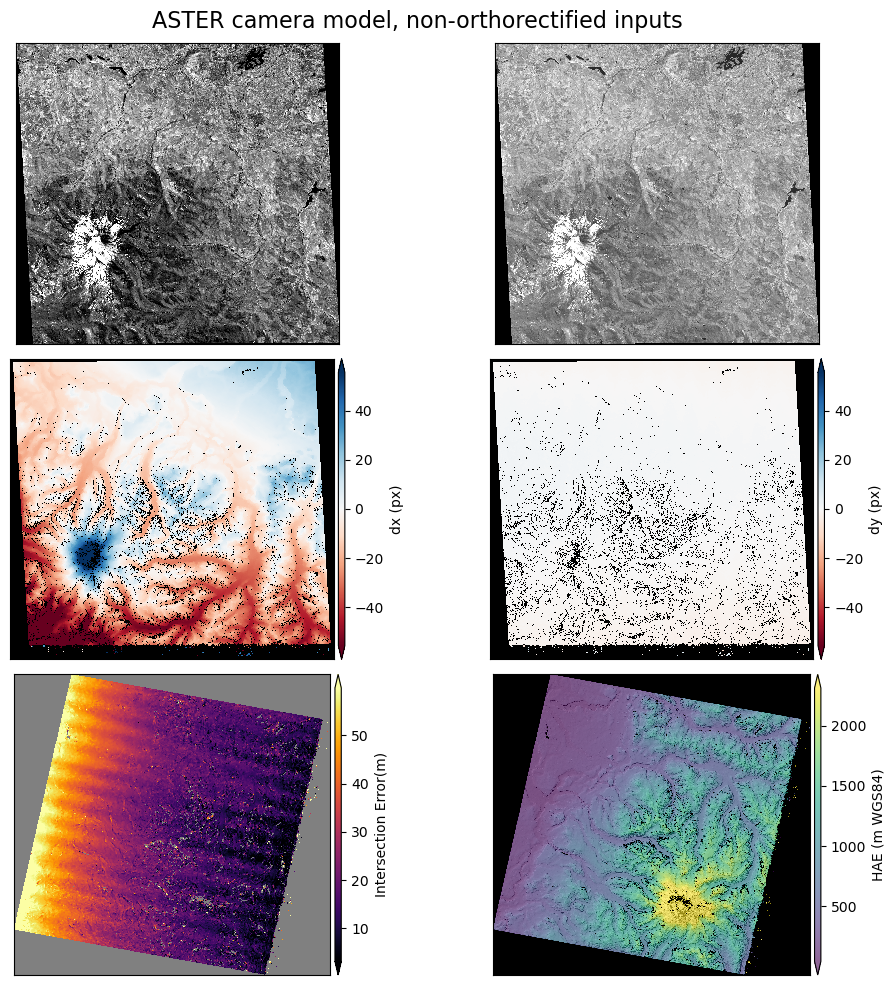

In [20]:
fig,ax = plt.subplots(3,2,figsize=(12,10))
asp_utils.plot_stereo_results(stereo_dir,ax)
fig.suptitle('ASTER camera model, non-orthorectified inputs', fontsize=16)
plt.tight_layout()

### 3.3 Use Orthorectified stereo inputs and ASTER camera model

- ASP can use orthorectified stereo input images
- Orthorectification helps in removing terrain disparity, helpful over steep areas (like the failed correlation over the Mt. Rainier volcano top. (see DEM above))
- When the point cloud triangulation occurs, the orthorectification is undone using the camera information and DEM.
- Here we will programmetically fetch SRTM DEM (GL1 Ellipsoidal) using the [opentopography api](https://portal.opentopography.org/apidocs/#/operations/Public) 
- The user will need to provide their opentopography api key which can be fetched by creating an account at [opentopography](https://opentopography.org/login)
- Input left and right image will be orthorectified using the downloaded SRTM DEM.
- The `stereo` and `point2dem` calls will then be evoked as usual.

#### Extent determination for dowmloading DEM from previous stereo output 

In [21]:
stereo_dir  = 'stereo_rpc/run'
dem_file = glob.glob(stereo_dir+'*-DEM.tif')[0]
# get aoi extent in geographic coordinates
aoi_extent = asp_utils.subsetBBox(dem_file,'EPSG:4326')
#in_crs = rasterio.open(dem_file).crs

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/workspaces/asp_tutorials/tutorials/asp_binder_utils.py:114: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
 

In [22]:
opentopo_api_key = 'demoapikeyot2022' #paste your open topography api key within the quotes
reference_srtm = opentopo_utils.get_dem('SRTMGL1_E',aoi_extent,apikey=opentopo_api_key,proj=tsrs)
reference_srtm

Deleting existing DEM file with same name as SRTMGL1_E.tif
https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1_E&west=-122.3493062657848&south=46.711450150858276&east=-121.34951915229212&north=47.34176397799961&outputFormat=GTiff&API_Key=demoapikeyot2022
OK!
/srv/conda/envs/notebook/bin/gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -s_srs 'EPSG:4326' -t_srs 'EPSG:32610' SRTMGL1_E_temp.tif SRTMGL1_E.tif
/srv/conda/envs/notebook/bin/gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -s_srs 'EPSG:4326' -t_srs 'EPSG:32610' SRTMGL1_E_temp.tif SRTMGL1_E.tif
Creating output file that is 3170P x 2930L.
Processing SRTMGL1_E_temp.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image SRTMGL1_E_temp.tif.
Copying nodata values from source SRTMGL1_E_temp.tif to destination SRTMGL1_E.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
/srv/conda/envs/notebook/bin/gdal_edit.py SRTMGL1_E.tif -a_srs EPSG:32610+EPSG:4979


Child returned 0
Child returned 0


'SRTMGL1_E.tif'

- We will now orthorectify the left and right stereo images using ASP's `mapproject` call and the adjusted SRTM DEM
- We will use the `rpc` camera for orthorectification (it is faster), while use the `rigrous ASTER` camera during triangulation, as it is more accurate.

In [23]:
mapproject = find_executable('mapproject')
l_map = os.path.splitext(l_img)[0]+'_map_utm.tif'
r_map = os.path.splitext(r_img)[0]+'_map_utm.tif'
mapproject_left_img_call = f"{mapproject} -t rpc --tr {map_res} --t_srs '{tsrs}' {reference_srtm} {l_img} {l_img_xml} {l_map}"
mapproject_right_img_call = f"{mapproject} -t rpc --tr {map_res} --t_srs '{tsrs}' {reference_srtm} {r_img} {r_img_xml} {r_map}"
asp_utils.run_bash_command(mapproject_left_img_call,verbose=verbose)
asp_utils.run_bash_command(mapproject_right_img_call,verbose=verbose)

/srv/StereoPipeline/bin/mapproject -t rpc --tr 15 --t_srs 'EPSG:32610' SRTMGL1_E.tif aster_example_asp/out-Band3N.tif aster_example_asp/out-Band3N.xml aster_example_asp/out-Band3N_map_utm.tif


Child returned 0


/srv/StereoPipeline/bin/mapproject -t rpc --tr 15 --t_srs 'EPSG:32610' SRTMGL1_E.tif aster_example_asp/out-Band3B.tif aster_example_asp/out-Band3B.xml aster_example_asp/out-Band3B_map_utm.tif


Child returned 0


- Now we can use the mapprojected image to rerun Stereo command
- This makes the process run faster during correlation stage, as the correlator's work in finding matches is reduced due to the smaller search range.
- Mapprojection improves correlation results in featureless or high sloped areas, like the snow-covered mountain tops

- The stereo call remains the same, we just need to update left and right image with their orthorectified ones, and provide a DEM after specifying the output directory, so that it can be used during triangulation to undo mapprojection

In [24]:
stereo = find_executable('stereo')
session = 'astermaprpc'
stereo_algorithm = 'asp_bm'
spm = 1 
stereo_dir  = 'stereo_aster_session_orthorectified/aster_orthorectified'
stereo_call = f'{stereo} -t {session} --skip-rough-homography --stereo-algorithm {stereo_algorithm} --subpixel-mode {spm} {l_map} {r_map} {l_img_xml} {r_img_xml} {stereo_dir} {reference_srtm}'
asp_utils.run_bash_command(stereo_call,verbose=verbose)

/srv/StereoPipeline/bin/stereo -t astermaprpc --skip-rough-homography --stereo-algorithm asp_bm --subpixel-mode 1 aster_example_asp/out-Band3N_map_utm.tif aster_example_asp/out-Band3B_map_utm.tif aster_example_asp/out-Band3N.xml aster_example_asp/out-Band3B.xml stereo_aster_session_orthorectified/aster_orthorectified SRTMGL1_E.tif


Child returned 0


In [25]:
point2dem = find_executable('point2dem')
tr = output_res
tsrs = tsrs
p2dem_args = '--errorimage'
pointcloud = glob.glob(stereo_dir+'*-PC.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call = f"{point2dem} --tr {tr} --t_srs '{tsrs}' {p2dem_args} {pointcloud}"
asp_utils.run_bash_command(point2dem_call,verbose=verbose)
dem = glob.glob(stereo_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(dem))

Gridding pointcloud stereo_aster_session_orthorectified/aster_orthorectified-PC.tif at 30 m/px
/srv/StereoPipeline/bin/point2dem --tr 30 --t_srs 'EPSG:32610' --errorimage stereo_aster_session_orthorectified/aster_orthorectified-PC.tif
DEM saved at stereo_aster_session_orthorectified/aster_orthorectified-DEM.tif


Child returned 0


Found files stereo_aster_session_orthorectified/aster_orthorectified-L.tif
 stereo_aster_session_orthorectified/aster_orthorectified-R.tif
 stereo_aster_session_orthorectified/aster_orthorectified-F.tif
 stereo_aster_session_orthorectified/aster_orthorectified-IntersectionErr.tif
 stereo_aster_session_orthorectified/aster_orthorectified-DEM.tif



/srv/conda/envs/notebook/lib/python3.9/site-packages/matplotlib/image.py:513: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)


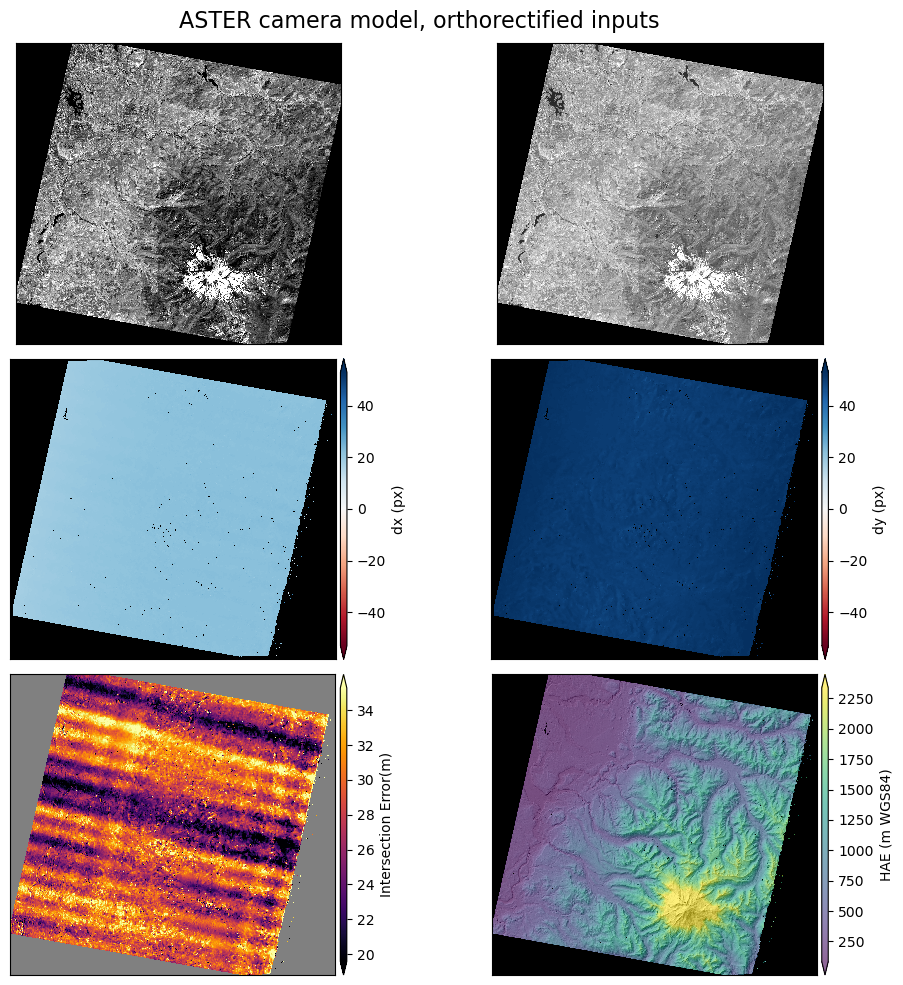

In [26]:
fig,ax = plt.subplots(3,2,figsize=(12,10))
asp_utils.plot_stereo_results(stereo_dir,ax)
fig.suptitle('ASTER camera model, orthorectified inputs', fontsize=16)
plt.tight_layout()

- Note the left and right images are oriented correctly (they are already orthorectified)
- The output DEM is complete over the volcano top